In [186]:
import torch.distributions as D
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 4

In [187]:
gt_mean = 0
gt_sigma = 4
target_dist = D.Normal(gt_mean, gt_sigma)
x = target_dist.sample((10000, 1))
omegas = torch.linspace(0., 1., 101)

In [206]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

from tqdm import tqdm
n_means = 40
n_sigmas = 40
means = torch.linspace(-2, 2, n_means)
sigmas = torch.linspace(3., 7., n_sigmas)
sigmas_grid, means_grid = torch.stack(torch.meshgrid(sigmas, means), dim=-1).reshape(-1, 2).T

# compute NegLogLike
test_dist = D.Normal(means_grid, sigmas_grid)
nll = -test_dist.log_prob(x).mean(0)

# # compute ECE with cdf
x_cdf_vals = test_dist.cdf(x)
x_cdf_vals = np.abs(x_cdf_vals - 0.5) * 2
freq = (x_cdf_vals.unsqueeze(0) <= omegas[:, None, None]).cpu().data.numpy().mean(1)
ece = np.abs(freq - omegas.cpu().data.numpy()[:, None]).mean(0)

# compute ECE with estimated error cdf
n_samples = 1000
samples = test_dist.sample((n_samples,))
median = samples.median(dim=0, keepdim=True)[0]
error = np.power(median - samples, 2)
true_error = np.power(median - x, 2)
q_vals = torch.quantile(error, omegas, dim=0) # get the error values correspondig to the quantiles
freq = (true_error.unsqueeze(0) <= q_vals.unsqueeze(1)).cpu().data.numpy().mean(1)
ece_from_error = np.abs(freq - omegas.cpu().data.numpy()[:, None]).mean(0)

# compute minMPJPE
ms = []
for i in tqdm(range(200)):
    test_samps = test_dist.sample((10, ))
    minmpjpe = torch.pow(test_samps - x.unsqueeze(-1), 2).sqrt().min(1).values.mean(0)
    ms.append(minmpjpe)

minmpjpe = torch.stack(ms).mean(0)

/var/folders/l0/5z9p4hy52cb1qp1y62gb48sw0000gn/T/ipykernel_65264/3759466756.py:28: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax2.contourf(minmpjpe.reshape(n_means, n_sigmas), origin="lower", extent=extent, aspect=aspect, cmap=cm, levels=15, vmin=0.84, vmax=1.15)
/var/folders/l0/5z9p4hy52cb1qp1y62gb48sw0000gn/T/ipykernel_65264/3759466756.py:51: UserWarning: The following kwargs were not used by contour: 'aspect'
  contour = ax4.contourf(ece.reshape(n_means, n_sigmas), origin="lower", extent=extent, aspect=aspect, cmap=cm, levels=10)


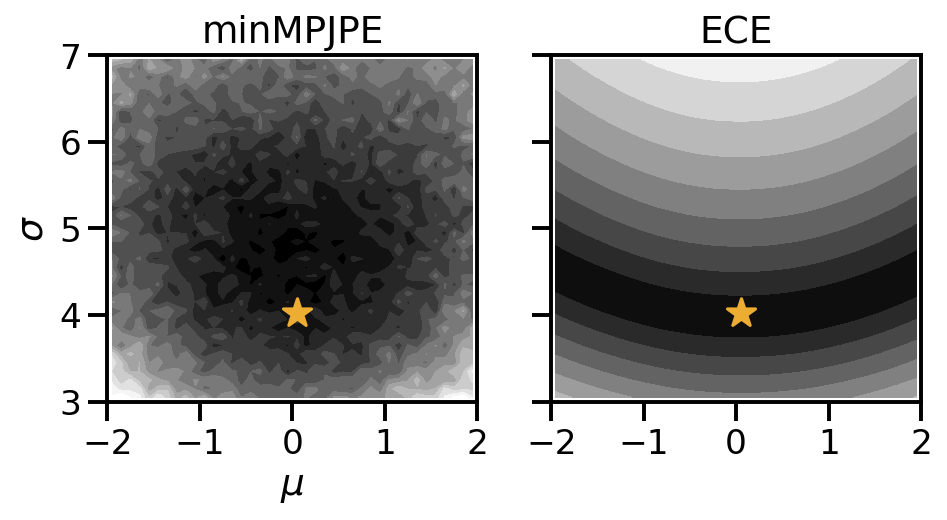

In [293]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*3.5, 3), dpi=150, sharey=True)

sns.set_context('talk')
fig.set_facecolor((1.0, 1., 1.))
for ax in [ax1, ax2]:
    ax.set_facecolor((1.0, 1., 1.))

extent = [means.min().numpy(), means.max().numpy(), sigmas.min().numpy(), sigmas.max().numpy()]
aspect = (means.max() - means.min()) / (sigmas.max() - sigmas.min())
cm = plt.cm.gray

sigma_idx, mean_idx = np.where(nll.reshape(n_means, n_sigmas) == nll.reshape(n_means, n_sigmas).min())
true_mean, true_sigma = means[mean_idx], sigmas[sigma_idx]

ax1.contourf(minmpjpe.reshape(n_means, n_sigmas), origin="lower", extent=extent, aspect=aspect, cmap=cm, levels=15, vmin=0.84, vmax=1.15)
sigma_idx, mean_idx = np.where(minmpjpe.reshape(n_means, n_sigmas) == minmpjpe.reshape(n_means, n_sigmas).min())
ax1.scatter(true_mean, true_sigma, c="#EDAC32", marker='*', s=200)
ax1.set_xlim(-2, 2)
ax1.set_ylim(3, 7)
ax1.set_xticks([-2, -1, 0, 1, 2])
ax1.set_title("minMPJPE")
ax1.set_xlabel(r"$\mu$")
ax1.set_ylabel(r"$\sigma$")

contour = ax2.contourf(ece.reshape(n_means, n_sigmas), origin="lower", extent=extent, aspect=aspect, cmap=cm, levels=10)
sigma_idx, mean_idx = np.where(ece_from_error.reshape(n_means, n_sigmas) == ece_from_error.reshape(n_means, n_sigmas).min())
_x_ = np.linspace(-2, 2)
ax2.scatter(true_mean, true_sigma, c="#EDAC32", marker='*', zorder=3, s=200)
ax2.set_xlim(-2, 2)
ax2.set_ylim(3, 7)
ax2.set_title("ECE")
ax2.set_xticks([-2, -1, 0, 1, 2])

fig.savefig('nll_vs_minmpjpe_landscape.pdf', bbox_inches='tight')

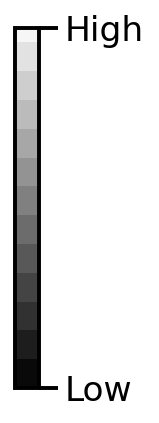

In [331]:
import pylab as pl

a = np.array([[0,1], [0,1]])
pl.figure(figsize=(0.2, 4), dpi=150)
img = pl.contourf(a, cmap=cm, levels=15)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(cax=cax)
plt.ylim(0, 1)
plt.yticks([0, 1], ['Low', 'High'])
plt.savefig('colorbar.pdf', bbox_inches='tight')